## Assignment 1

#### Preparation

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
from sqlalchemy import create_engine

In [4]:
conn_string_fb = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='facebook'
)
engine_fb = create_engine(conn_string_fb)

### Estimations of Political Views based on Favorite Books

In class, we used the Facebook database and examined how to compute the log-odds between liberal-conservative for each book.

For this homework, you are asked to expand the analysis, and try to estimate political leanings of students based on their book preferences, and see whether the predicted score matches their declared political view. 

To estimate a "PoliticalView_based_on_Books", you can sum up, for each student, the log-odds of the books that they liked. The sum of the log-odds will show how conservative or how liberal a person in leaning, based on the books they liked.


#### 1.	Create a dataframe with the log-odds of the books. 

In [5]:
books_views = '''
SELECT B.Book, P.PoliticalViews, COUNT(*) AS cnt 
FROM Profiles P INNER JOIN FavoriteBooks B ON P.ProfileID = B.ProfileID
WHERE (P.PoliticalViews = 'Liberal' OR P.PoliticalViews = 'Conservative') 
    AND B.Book IS NOT NULL
    AND P.PoliticalViews IS NOT NULL
GROUP BY B.Book, P.PoliticalViews
HAVING cnt > 5
'''

df_books_views = pd.read_sql(books_views, con = engine_fb)
df_books_views.head(10)

,Book,PoliticalViews,cnt
0,100 Years Of Solitude,Liberal,55
1,1984,Conservative,32
2,1984,Liberal,286
3,1984 Orwell,Liberal,6
4,5 People You Meet In Heaven,Liberal,7
5,A Brave New World,Liberal,7
6,A Brief History Of Time,Liberal,7
7,A Clockwork Orange,Conservative,8
8,A Clockwork Orange,Liberal,86
9,A Confederacy Of Dunces,Liberal,37


In [6]:
dfp = df_books_views.pivot_table(
    index = 'Book',
    columns = 'PoliticalViews',
    values = 'cnt'
)
dfp.head(10)

PoliticalViews,Conservative,Liberal
Book,,
100 Years Of Solitude,NaN,55.0
1984,32.0,286.0
1984 Orwell,NaN,6.0
5 People You Meet In Heaven,NaN,7.0
A Brave New World,NaN,7.0
A Brief History Of Time,NaN,7.0
A Clockwork Orange,8.0,86.0
A Confederacy Of Dunces,NaN,37.0
A Doll S House,NaN,12.0


In [7]:
dfp = dfp.fillna(0)
dfp.head(10)

PoliticalViews,Conservative,Liberal
Book,,
100 Years Of Solitude,0.0,55.0
1984,32.0,286.0
1984 Orwell,0.0,6.0
5 People You Meet In Heaven,0.0,7.0
A Brave New World,0.0,7.0
A Brief History Of Time,0.0,7.0
A Clockwork Orange,8.0,86.0
A Confederacy Of Dunces,0.0,37.0
A Doll S House,0.0,12.0


In [8]:
polviews = '''
SELECT PoliticalViews, COUNT(*) AS cnt 
FROM Profiles
WHERE PoliticalViews = 'Liberal' OR PoliticalViews = 'Conservative'
GROUP BY PoliticalViews
'''

df_polviews = pd.read_sql(polviews, con = engine_fb)
df_polviews

,PoliticalViews,cnt
0,Conservative,936
1,Liberal,6461


In [9]:
# Normalize
# Calculates the percentage of liberal and conservative students that liked each book
# Add 1 in the numerator to avoid division by zero

dfp["Liberal_perc"] = (dfp["Liberal"] +1)  / df_polviews.iloc[1]['cnt']
dfp["Conservative_perc"] = (dfp["Conservative"] +1)  / df_polviews.iloc[0]['cnt']

dfp.head(10)

PoliticalViews,Conservative,Liberal,Liberal_perc,Conservative_perc
Book,,,,
100 Years Of Solitude,0.0,55.0,0.008667,0.001068
1984,32.0,286.0,0.044420,0.035256
1984 Orwell,0.0,6.0,0.001083,0.001068
5 People You Meet In Heaven,0.0,7.0,0.001238,0.001068
A Brave New World,0.0,7.0,0.001238,0.001068
A Brief History Of Time,0.0,7.0,0.001238,0.001068
A Clockwork Orange,8.0,86.0,0.013465,0.009615
A Confederacy Of Dunces,0.0,37.0,0.005881,0.001068
A Doll S House,0.0,12.0,0.002012,0.001068


In [10]:
# Calculate the lift for each book

dfp["lift_liberal"] = dfp["Liberal_perc"] / dfp["Conservative_perc"]
dfp["lift_conservative"] = dfp["Conservative_perc"]  / dfp["Liberal_perc"]

dfp.head(10)

PoliticalViews,Conservative,Liberal,Liberal_perc,Conservative_perc,lift_liberal,lift_conservative
Book,,,,,,
100 Years Of Solitude,0.0,55.0,0.008667,0.001068,8.112676,0.123264
1984,32.0,286.0,0.044420,0.035256,1.259923,0.793699
1984 Orwell,0.0,6.0,0.001083,0.001068,1.014085,0.986111
5 People You Meet In Heaven,0.0,7.0,0.001238,0.001068,1.158954,0.862847
A Brave New World,0.0,7.0,0.001238,0.001068,1.158954,0.862847
A Brief History Of Time,0.0,7.0,0.001238,0.001068,1.158954,0.862847
A Clockwork Orange,8.0,86.0,0.013465,0.009615,1.400402,0.714080
A Confederacy Of Dunces,0.0,37.0,0.005881,0.001068,5.505030,0.181652
A Doll S House,0.0,12.0,0.002012,0.001068,1.883300,0.530983


The lift is the ratio between the percentage of liberals and the percentage of convervatives. 

A book with **lift equal to 1** will be **equally read** by both conservatives and liberals. 

Books that have **lifts (significantly) higher than 1** will be read **(a lot) more by liberals** while those with **lifts (significantly) lower than 1** will be read **(a lot) more by conservatives**.


In [11]:
# Calculate the log odds

dfp["log_odds_liberal"]      =  np.log(dfp["lift_liberal"])
dfp["log_odds_conservative"] =  np.log(dfp["lift_conservative"])

dfp.head(10)

PoliticalViews,Conservative,Liberal,Liberal_perc,Conservative_perc,lift_liberal,lift_conservative,log_odds_liberal,log_odds_conservative
Book,,,,,,,,
100 Years Of Solitude,0.0,55.0,0.008667,0.001068,8.112676,0.123264,2.093428,-2.093428
1984,32.0,286.0,0.044420,0.035256,1.259923,0.793699,0.231051,-0.231051
1984 Orwell,0.0,6.0,0.001083,0.001068,1.014085,0.986111,0.013986,-0.013986
5 People You Meet In Heaven,0.0,7.0,0.001238,0.001068,1.158954,0.862847,0.147518,-0.147518
A Brave New World,0.0,7.0,0.001238,0.001068,1.158954,0.862847,0.147518,-0.147518
A Brief History Of Time,0.0,7.0,0.001238,0.001068,1.158954,0.862847,0.147518,-0.147518
A Clockwork Orange,8.0,86.0,0.013465,0.009615,1.400402,0.714080,0.336760,-0.336760
A Confederacy Of Dunces,0.0,37.0,0.005881,0.001068,5.505030,0.181652,1.705662,-1.705662
A Doll S House,0.0,12.0,0.002012,0.001068,1.883300,0.530983,0.633025,-0.633025


In [12]:
df_logoddsbooks = dfp[["log_odds_liberal", "log_odds_conservative"]]  
df_logoddsbooks.head(10)

PoliticalViews,log_odds_liberal,log_odds_conservative
Book,,
100 Years Of Solitude,2.093428,-2.093428
1984,0.231051,-0.231051
1984 Orwell,0.013986,-0.013986
5 People You Meet In Heaven,0.147518,-0.147518
A Brave New World,0.147518,-0.147518
A Brief History Of Time,0.147518,-0.147518
A Clockwork Orange,0.336760,-0.336760
A Confederacy Of Dunces,1.705662,-1.705662
A Doll S House,0.633025,-0.633025


Therefore, `lift==1` corresponds to a `log_odds==0`. Negative values indicate negative association, and positive values indicate positive association. Values of log_odds_conservative are exactly the opposite of those of log_odds_liberal.

**Books with positive log_odds_liberal are more likely to be read by liberals**.

**Books with negative log_odds_liberal are more likely to be read by conservatives**.

#### 2.	Join the dataframe with the log-odds with the FavoriteBooks table. Use the "merge" command of Pandas, to perform the join using only Pandas dataframes.

In [13]:
favoritebooks ='''
SELECT * 
FROM FavoriteBooks
'''

df_favoritebooks = pd.read_sql(favoritebooks, con = engine_fb)
df_favoritebooks.head(10)

,ProfileID,Book
0,800002,Books Are For Suckers
1,800004,Mansfield Park
2,800004,Memoirs Of A Geisha
3,800004,Harry Potter All
4,800004,A Gesture Life
5,800004,Queen Of Camelot
6,800004,Middlesex
7,800004,Cat S Cradle
8,800004,Diary
9,800004,The Bible


In [14]:
df_students = df_favoritebooks.merge(df_logoddsbooks,
              how = 'inner',
              left_on = 'Book',
              right_index = True
)
df_students

,ProfileID,Book,log_odds_liberal,log_odds_conservative
2,800004,Memoirs Of A Geisha,0.450704,-0.450704
82,800019,Memoirs Of A Geisha,0.450704,-0.450704
91,800021,Memoirs Of A Geisha,0.450704,-0.450704
1128,800288,Memoirs Of A Geisha,0.450704,-0.450704
1367,800343,Memoirs Of A Geisha,0.450704,-0.450704
1672,800424,Memoirs Of A Geisha,0.450704,-0.450704
2015,802952,Memoirs Of A Geisha,0.450704,-0.450704
2221,803010,Memoirs Of A Geisha,0.450704,-0.450704
2258,803022,Memoirs Of A Geisha,0.450704,-0.450704
2452,803076,Memoirs Of A Geisha,0.450704,-0.450704


In [15]:
df_students = df_students.sort_values("ProfileID")
df_students

,ProfileID,Book,log_odds_liberal,log_odds_conservative
2,800004,Memoirs Of A Geisha,0.450704,-0.450704
6,800004,Middlesex,2.567886,-2.567886
9,800004,The Bible,-1.764870,1.764870
8,800004,Diary,0.370661,-0.370661
7,800004,Cat S Cradle,0.370661,-0.370661
3,800004,Harry Potter All,0.013986,-0.013986
11,800005,Night,0.776126,-0.776126
13,800005,Catcher In The Rye,0.687461,-0.687461
12,800005,Catch 22,0.304910,-0.304910
18,800006,Dry,0.901289,-0.901289


#### 3.	Compute the log-odds score for each student.

In [16]:
df_scores = df_students.groupby("ProfileID")[["log_odds_liberal"]].sum()
df_scores.head(10)

,log_odds_liberal
ProfileID,
800004,2.009028
800005,1.768497
800006,5.421864
800010,3.778719
800011,-7.438136
800012,4.802299
800015,2.038368
800017,0.763316
800018,1.138755


In [17]:
# Rename the column
df_scores.columns = ['log_odds_score']
df_scores.head(10)

,log_odds_score
ProfileID,
800004,2.009028
800005,1.768497
800006,5.421864
800010,3.778719
800011,-7.438136
800012,4.802299
800015,2.038368
800017,0.763316
800018,1.138755


The sum of the log-odds of the books one liked will show how conservative or how liberal a person in leaning.

Students with positive scores are generally considered as liberals. 

**The greater the positive score, the stronger leaning towards the liberal side of the political spectrum. **

Students with negative scores are generally considered as conservatives. 

**The lower the negative score, the stronger leaning towards the conservative side of the political spectrum. **


#### 4.	To evaluate the technique, calculate the average value of the log-odds for students that are liberals, conservatives, very liberals, very conservatives, and moderates.

In [18]:
views = '''
SELECT ProfileID, PoliticalViews
FROM Profiles
WHERE PoliticalViews IS NOT NULL
'''

df_views = pd.read_sql(views, con = engine_fb)
df_views.head(10)

,ProfileID,PoliticalViews
0,800002,Libertarian
1,800004,Conservative
2,800008,Liberal
3,800010,Apathetic
4,800011,Conservative
5,800012,Liberal
6,800013,Liberal
7,800015,Liberal
8,800016,Moderate
9,800017,Liberal


In [19]:
df_views_scores = df_views.merge(
    df_scores,
    how = 'inner',
    left_on = 'ProfileID',
    right_index = True
)
df_views_scores.head(10)

,ProfileID,PoliticalViews,log_odds_score
1,800004,Conservative,2.009028
3,800010,Apathetic,3.778719
4,800011,Conservative,-7.438136
5,800012,Liberal,4.802299
7,800015,Liberal,2.038368
9,800017,Liberal,0.763316
10,800019,Very Liberal,6.232428
11,800020,Moderate,0.013986
12,800021,Conservative,4.205262
14,800023,Apathetic,-0.780632


In [20]:
df_means = df_views_scores.groupby("PoliticalViews")[["log_odds_score"]].mean()
df_means = df_means.sort_values("log_odds_score", ascending = False)
df_means.columns = ['mean log_odds']
df_means

,mean log_odds
PoliticalViews,
Very Liberal,3.746550
Liberal,3.132422
Libertarian,2.756758
Other,2.366185
Apathetic,2.296059
Moderate,2.123157
Very Conservative,1.120909
Conservative,0.832898


In [21]:
df = df_means.loc[["Very Liberal", "Liberal", "Moderate", "Conservative", "Very Conservative"]]
df

,mean log_odds
PoliticalViews,
Very Liberal,3.746550
Liberal,3.132422
Moderate,2.123157
Conservative,0.832898
Very Conservative,1.120909


Ideally, as the political views range from the most liberal to the least liberal (most conservative), the mean log_odds should decrease, the values for very liberal and liberal should be positive, the value for moderate should be around 0, the values for conservative and very conservative should be negative.

In this case, all mean log_odds are positive, meaning the three non-liberal views are more liberal than they should be. In other words, the books that are regarded as more liberal are liked by not that liberal people as well. Also, the value for the very conservatives is a bit larger than that for the conservatives, suggesting based on the books they read the very conservatives are more liberal than the conservatives, which should be the other way around. The technique is not very reliable as there're not only political reasons for people to read and like books.



#### 5. Create a histogram of the log-odds of the scores for each of the  liberals, conservatives, very liberals, very conservatives, and moderates. 

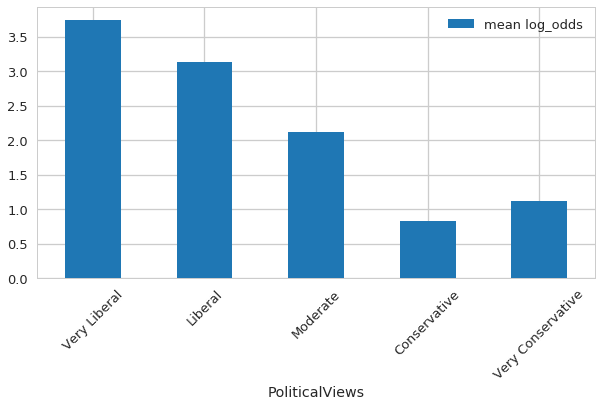

In [22]:
df.plot(kind = 'bar', rot = 45)

Once you are done with the analysis for FavoriteBooks, repeat the process for other attributes that we have in the database (e.g., FavoriteMovies, FavoriteMusic, FavoriteTVShows, etc)

### Estimations of Political Views based on Favorite Music

In [23]:
music_views = '''
SELECT M.Music, P.PoliticalViews, COUNT(*) AS cnt 
FROM Profiles P INNER JOIN FavoriteMusic M ON P.ProfileID = M.ProfileID
WHERE (P.PoliticalViews = 'Liberal' OR P.PoliticalViews = 'Conservative') 
    AND M.Music IS NOT NULL
    AND P.PoliticalViews IS NOT NULL
GROUP BY M.Music, P.PoliticalViews
HAVING cnt > 5
'''

df_music_views = pd.read_sql(music_views, con = engine_fb)
df_music_views.head(10)

,Music,PoliticalViews,cnt
0,112,Liberal,20
1,12 Stones,Liberal,6
2,2 Pac,Liberal,6
3,2Pac,Conservative,9
4,2Pac,Liberal,67
5,3 Doors Down,Conservative,9
6,3 Doors Down,Liberal,42
7,30 Seconds To Mars,Liberal,12
8,311,Conservative,20
9,311,Liberal,110


In [24]:
dfp = df_music_views.pivot_table(
    index = "Music",
    columns = "PoliticalViews",
    values = "cnt"
)
dfp.head(10)

PoliticalViews,Conservative,Liberal
Music,,
112,NaN,20.0
12 Stones,NaN,6.0
2 Pac,NaN,6.0
2Pac,9.0,67.0
3 Doors Down,9.0,42.0
30 Seconds To Mars,NaN,12.0
311,20.0,110.0
50,NaN,13.0
50 Cent,26.0,96.0


In [25]:
dfp = dfp.fillna(0)
dfp.head(10)

PoliticalViews,Conservative,Liberal
Music,,
112,0.0,20.0
12 Stones,0.0,6.0
2 Pac,0.0,6.0
2Pac,9.0,67.0
3 Doors Down,9.0,42.0
30 Seconds To Mars,0.0,12.0
311,20.0,110.0
50,0.0,13.0
50 Cent,26.0,96.0


In [27]:
dfp["Liberal_perc"] = (dfp["Liberal"] +1)  / df_polviews.iloc[1]['cnt']
dfp["Conservative_perc"] = (dfp["Conservative"] +1)  / df_polviews.iloc[0]['cnt']

dfp.head(10)

PoliticalViews,Conservative,Liberal,Liberal_perc,Conservative_perc
Music,,,,
112,0.0,20.0,0.003250,0.001068
12 Stones,0.0,6.0,0.001083,0.001068
2 Pac,0.0,6.0,0.001083,0.001068
2Pac,9.0,67.0,0.010525,0.010684
3 Doors Down,9.0,42.0,0.006655,0.010684
30 Seconds To Mars,0.0,12.0,0.002012,0.001068
311,20.0,110.0,0.017180,0.022436
50,0.0,13.0,0.002167,0.001068
50 Cent,26.0,96.0,0.015013,0.028846


In [28]:
dfp["lift_liberal"] = dfp["Liberal_perc"] / dfp["Conservative_perc"]
dfp["lift_conservative"] = dfp["Conservative_perc"]  / dfp["Liberal_perc"]

dfp.head(10)

PoliticalViews,Conservative,Liberal,Liberal_perc,Conservative_perc,lift_liberal,lift_conservative
Music,,,,,,
112,0.0,20.0,0.003250,0.001068,3.042254,0.328704
12 Stones,0.0,6.0,0.001083,0.001068,1.014085,0.986111
2 Pac,0.0,6.0,0.001083,0.001068,1.014085,0.986111
2Pac,9.0,67.0,0.010525,0.010684,0.985111,1.015114
3 Doors Down,9.0,42.0,0.006655,0.010684,0.622938,1.605297
30 Seconds To Mars,0.0,12.0,0.002012,0.001068,1.883300,0.530983
311,20.0,110.0,0.017180,0.022436,0.765737,1.305931
50,0.0,13.0,0.002167,0.001068,2.028169,0.493056
50 Cent,26.0,96.0,0.015013,0.028846,0.520456,1.921392


In [29]:
dfp["log_odds_liberal"]      =  np.log(dfp["lift_liberal"])
dfp["log_odds_conservative"] =  np.log(dfp["lift_conservative"])

dfp.head(10)

PoliticalViews,Conservative,Liberal,Liberal_perc,Conservative_perc,lift_liberal,lift_conservative,log_odds_liberal,log_odds_conservative
Music,,,,,,,,
112,0.0,20.0,0.003250,0.001068,3.042254,0.328704,1.112599,-1.112599
12 Stones,0.0,6.0,0.001083,0.001068,1.014085,0.986111,0.013986,-0.013986
2 Pac,0.0,6.0,0.001083,0.001068,1.014085,0.986111,0.013986,-0.013986
2Pac,9.0,67.0,0.010525,0.010684,0.985111,1.015114,-0.015001,0.015001
3 Doors Down,9.0,42.0,0.006655,0.010684,0.622938,1.605297,-0.473309,0.473309
30 Seconds To Mars,0.0,12.0,0.002012,0.001068,1.883300,0.530983,0.633025,-0.633025
311,20.0,110.0,0.017180,0.022436,0.765737,1.305931,-0.266916,0.266916
50,0.0,13.0,0.002167,0.001068,2.028169,0.493056,0.707133,-0.707133
50 Cent,26.0,96.0,0.015013,0.028846,0.520456,1.921392,-0.653050,0.653050


In [30]:
df_logoddsmusic = dfp[["log_odds_liberal", "log_odds_conservative"]]  
df_logoddsmusic.head(10)

PoliticalViews,log_odds_liberal,log_odds_conservative
Music,,
112,1.112599,-1.112599
12 Stones,0.013986,-0.013986
2 Pac,0.013986,-0.013986
2Pac,-0.015001,0.015001
3 Doors Down,-0.473309,0.473309
30 Seconds To Mars,0.633025,-0.633025
311,-0.266916,0.266916
50,0.707133,-0.707133
50 Cent,-0.653050,0.653050


In [31]:
favoritemusic ='''
SELECT * 
FROM FavoriteMusic
'''

df_favoritemusic = pd.read_sql(favoritemusic, con = engine_fb)
df_favoritemusic.head(10)

,ProfileID,Music
0,800002,Mf Doom Et Al
1,800002,Sergei Rachmaninov
2,800002,Bill Evans
3,800002,Lovage
4,800002,Rjd2
5,800002,2Pac
6,800002,Led Zeppelin
7,800002,Radiohead
8,800002,Jon Brion
9,800002,Britney Spears


In [32]:
df_students = df_favoritemusic.merge(df_logoddsmusic,
              how = 'inner',
              left_on = 'Music',
              right_index = True
)
df_students

,ProfileID,Music,log_odds_liberal,log_odds_conservative
2,800002,Bill Evans,0.958448,-0.958448
9610,800907,Bill Evans,0.958448,-0.958448
12982,801323,Bill Evans,0.958448,-0.958448
13949,801431,Bill Evans,0.958448,-0.958448
16718,801717,Bill Evans,0.958448,-0.958448
17418,801802,Bill Evans,0.958448,-0.958448
18598,801957,Bill Evans,0.958448,-0.958448
30172,803526,Bill Evans,0.958448,-0.958448
31931,803757,Bill Evans,0.958448,-0.958448
40762,804981,Bill Evans,0.958448,-0.958448


In [33]:
df_students = df_students.sort_values("ProfileID")
df_students

,ProfileID,Music,log_odds_liberal,log_odds_conservative
2,800002,Bill Evans,0.958448,-0.958448
6,800002,Led Zeppelin,-0.015001,0.015001
7,800002,Radiohead,1.033349,-1.033349
8,800002,Jon Brion,1.469273,-1.469273
9,800002,Britney Spears,2.075409,-2.075409
4,800002,Rjd2,2.111127,-2.111127
5,800002,2Pac,-0.015001,0.015001
11,800004,Coldplay,0.340670,-0.340670
12,800004,Andrea Bocelli,0.776126,-0.776126
13,800004,Frou Frou,0.590162,-0.590162


In [34]:
df_scores = df_students.groupby("ProfileID")[["log_odds_liberal"]].sum()
df_scores.columns = ['log_odds_score']
df_scores.head(10)

,log_odds_score
ProfileID,
800002,7.617605
800004,-0.298410
800005,6.591988
800006,4.844162
800010,8.274657
800011,0.267400
800012,5.645218
800015,5.190594
800017,11.317340


In [35]:
views = '''
SELECT ProfileID, PoliticalViews
FROM Profiles
WHERE PoliticalViews IS NOT NULL
'''

df_views = pd.read_sql(views, con = engine_fb)
df_views.head(10)

,ProfileID,PoliticalViews
0,800002,Libertarian
1,800004,Conservative
2,800008,Liberal
3,800010,Apathetic
4,800011,Conservative
5,800012,Liberal
6,800013,Liberal
7,800015,Liberal
8,800016,Moderate
9,800017,Liberal


In [36]:
df_views_scores = df_views.merge(
    df_scores,
    how = 'inner',
    left_on = 'ProfileID',
    right_index = True
)
df_views_scores.head(10)

,ProfileID,PoliticalViews,log_odds_score
0,800002,Libertarian,7.617605
1,800004,Conservative,-0.298410
3,800010,Apathetic,8.274657
4,800011,Conservative,0.267400
5,800012,Liberal,5.645218
7,800015,Liberal,5.190594
9,800017,Liberal,11.317340
10,800019,Very Liberal,7.210666
12,800021,Conservative,3.013801
14,800023,Apathetic,1.074583


In [38]:
df_means = df_views_scores.groupby("PoliticalViews")[["log_odds_score"]].mean()
df_means = df_means.sort_values("log_odds_score", ascending = False)
df_means.columns = ['mean log_odds']
df_means

,mean log_odds
PoliticalViews,
Very Liberal,14.402557
Other,12.348126
Liberal,11.484725
Libertarian,10.314485
Apathetic,9.671279
Moderate,7.114763
Very Conservative,4.521527
Conservative,3.996240


In [39]:
df = df_means.loc[["Very Liberal", "Liberal", "Moderate", "Conservative", "Very Conservative"]]
df

,mean log_odds
PoliticalViews,
Very Liberal,14.402557
Liberal,11.484725
Moderate,7.114763
Conservative,3.996240
Very Conservative,4.521527


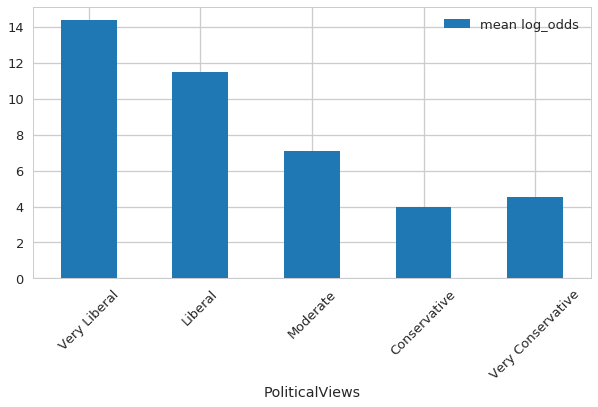

In [40]:
df.plot(kind = 'bar', rot = 45)

Using this technique on favorite music gives nearly the same results. Moderate, conservative, very conservative people love music pieces that are judged as more liberal. The very conservatives are slightly more liberal than the conservatives. 